In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
from scipy.interpolate import interp1d
import warnings
import scipy.stats as stats
from scipy.optimize import minimize_scalar
warnings.filterwarnings('ignore')

In [47]:
pd.set_option('display.float_format', '{:.2f}'.format)

In [48]:
ruta=r'/Users/juansierra/Downloads/datos_longevidad.xlsx'
data=pd.read_excel(ruta,'Data')
print(data.columns)
data=data[['Edad', 'Casado', 'Genero','Edad_pareja', 'Sexo_pareja', 'Pago_mensual']]
data.head()

Index(['Unnamed: 0', 'Edad', 'Casado', 'Genero', 'Edad_pareja', 'Sexo_pareja',
       'Pago_mensual'],
      dtype='object')


,Edad,Casado,Genero,Edad_pareja,Sexo_pareja,Pago_mensual
0,68,0,M,0,0,4196583.06
1,67,1,H,67,H,1983941.40
2,80,1,H,77,H,4014628.81
3,71,1,H,85,M,5710179.97
4,66,0,M,0,0,7882172.76


In [49]:
def TMensual(Tmort):
    """
    Interpola los valores de l(x) en pasos de 1/12 (mensual) y calcula q(x) y p(x).

    Parameters:
    Tmort (DataFrame): DataFrame que contiene las columnas 'x' y 'l(x)'.

    Returns:
    DataFrame: DataFrame con valores interpolados de x, l(x), q(x) y p(x).
    """

    # Aseguramos que Tmort tiene las columnas adecuadas
    if 'x' not in Tmort.columns or 'l(x)' not in Tmort.columns:
        raise ValueError("El DataFrame debe contener las columnas 'x' y 'l(x)'")

    # Obtener los valores de x y l(x)
    x_values = Tmort['x'].values
    lx_values = Tmort['l(x)'].values

    # Crear una función de interpolación
    interp_function = interp1d(x_values, lx_values, kind='linear', fill_value='extrapolate')

    # Crear los nuevos valores de x con un paso de 1/12, hasta 110 (incluyendo 110)
    new_x = np.arange(x_values[0], 110 + 1/12, 1/12)  # Incrementos mensuales hasta 110

    # Calcular los valores de l(x) interpolados
    new_lx = interp_function(new_x)

    # Inicializar los arrays para q(x) y p(x)
    qx_values = np.zeros(len(new_x) - 1)  # Inicializar el array para q(x)
    px_values = np.zeros(len(new_x) - 1)  # Inicializar el array para p(x)

    # Calcular q(x) y p(x) para cada nuevo valor de x
    for i in range(len(new_x)-1):
        if new_lx[i] > 0:  # Evitar división por cero
            qx_values[i] = 1 - (new_lx[i + 1] / new_lx[i])  # q(x) = 1 - l(x + 1/12) / l(x)
        else:
            qx_values[i] = 0  # Si l(x) es 0, q(x) también debe ser 0

        px_values[i] = 1 - qx_values[i]  # p(x) = 1 - q(x)


    # Crear un nuevo DataFrame con los valores interpolados y calculados
    interpolated_df = pd.DataFrame({
        'x': new_x,  # Incluir hasta 110
        'l(x)': new_lx,  # Excluir el último por la misma razón
        'q(x)': np.append(qx_values, 1),  # Añadir el valor de q(110)
        'p(x)': np.append(px_values, 0)  # Añadir el valor de p(110)
    })

    return interpolated_df

def tmort_filtered(df,edad):
    qx_vec=df[df['x']>=edad]
    return qx_vec

In [50]:
##Finanzas - Interes Compuesto

def vf_cte(pago, n, i):

#Pago -> Valor de la mensualidad
#n -> Número de periodos
#i -> Interes de la periodicidad n

  pagos = np.ones(n) * pago
  print(pagos.sum())
  cao_factor = np.ones(n) * (1 + i) ** np.arange(n,0,-1)
  resp_vector = pagos * cao_factor
  resp = resp_vector.sum()
  return resp

In [51]:
Tmort_h = pd.read_excel('/Users/juansierra/Downloads/TM_hombres.xlsx')
Tmort_m= pd.read_excel('/Users/juansierra/Downloads/TM_mujeres.xlsx')
T_hombre = TMensual(Tmort_h)
T_mujer = TMensual(Tmort_m)

In [52]:
valoracion_jubilado = []
valoracion_pareja = []
i = 0.04 / 12

for index, row in data.iterrows():
    genero = row['Genero']
    if genero == 'H':
        tmort = T_hombre
    else:
        tmort = T_mujer

    if row['Casado'] == 0:
        # Renta Vitalicia
        edad = row['Edad']
        pago = row['Pago_mensual']
        T = tmort_filtered(tmort, edad)
        T['n'] = T['x'].apply(lambda x: x - edad) * 12
        T['Vn'] = np.ones(len(T)) * (1 / (1 + i))
        T['Vn'] = T.apply(lambda row: row['Vn'] ** row['n'], axis=1)
        sum_vect = pago * T['Vn'] * T['p(x)']
        va_jubilado = sum_vect.sum()
        va_pareja = 0
        valoracion_jubilado.append(va_jubilado)
        valoracion_pareja.append(va_pareja)

    elif row['Casado'] == 1:
        # Renta Vitalicia Reversible
        edad = row['Edad']
        pago = row['Pago_mensual']
        T = tmort_filtered(tmort, edad)
        T['n'] = T['x'].apply(lambda x: x - edad) * 12
        T['Vn'] = np.ones(len(T)) * (1 / (1 + i))
        T['Vn'] = T.apply(lambda row: row['Vn'] ** row['n'], axis=1)
        sum_vect = pago * T['Vn'] * T['p(x)']
        va_jubilado = sum_vect.sum()

        edad_pareja = row['Edad_pareja']
        genero_pareja = row['Sexo_pareja']
        if genero_pareja == 'H':
            tmort_pareja = T_hombre
        else:
            tmort_pareja = T_mujer

        T_par = tmort_filtered(tmort_pareja, edad_pareja)
        T_par['n'] = T_par['x'].apply(lambda x: x - edad_pareja) * 12
        T_par['Vn'] = np.ones(len(T_par)) * (1 / (1 + i))
        T_par['Vn'] = T_par.apply(lambda row: row['Vn'] ** row['n'], axis=1)

        if edad <= edad_pareja:
            T_par['q(x)_Jub'] = T['q(x)'][:len(T_par)]
        else:
            lista = []
            gap = (edad - edad_pareja) * 12
            lista = list(T['q(x)']) + list(np.ones(gap))
            T_par['q(x)_Jub'] = lista

        sum_vect_pareja = pago * T_par['Vn'] * T_par['p(x)'] * T_par['q(x)_Jub']
        va_pareja = sum_vect_pareja.sum()

        valoracion_jubilado.append(va_jubilado)
        valoracion_pareja.append(va_pareja)

data['Valoracion Jubilado'] = valoracion_jubilado
data['valoracion pareja'] = valoracion_pareja
data['Pago_mensual'] = data['Pago_mensual'].apply(lambda x: f'{x:,.2f}')
data['Valoracion'] = data['Valoracion Jubilado'] + data['valoracion pareja']

In [53]:
data.head()

,Edad,Casado,Genero,Edad_pareja,Sexo_pareja,Pago_mensual,Valoracion Jubilado,valoracion pareja,Valoracion
0,68,0,M,0,0,"4,196,583.06",1017456036.16,0.00,1017456036.16
1,67,1,H,67,H,"1,983,941.40",484784234.22,4985840.73,489770074.95
2,80,1,H,77,H,"4,014,628.81",828188996.93,53608562.26,881797559.19
3,71,1,H,85,M,"5,710,179.97",1339739654.76,6941368.13,1346681022.89
4,66,0,M,0,0,"7,882,172.76",1946327113.36,0.00,1946327113.36


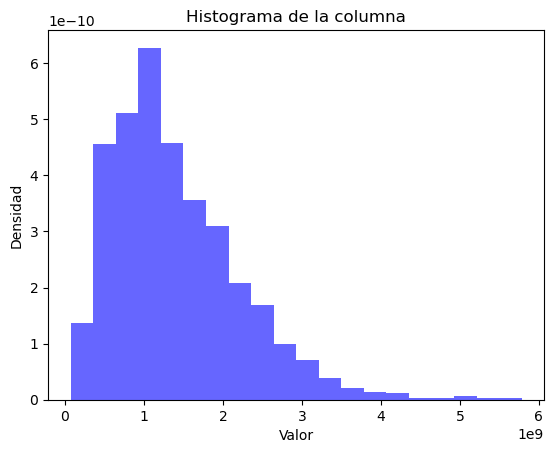

In [54]:
plt.hist(data['Valoracion'], bins=20, density=True, alpha=0.6, color='b')
plt.xlabel('Valor')
plt.ylabel('Densidad')
plt.title('Histograma de la columna')
plt.show()

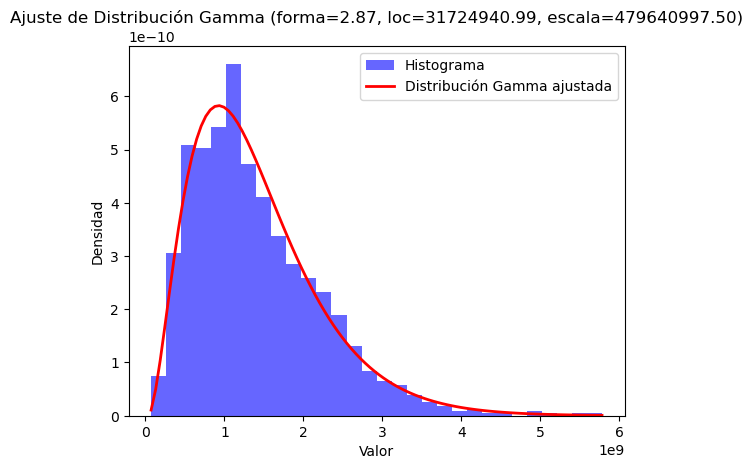

In [55]:
#Ajustar la distribución gamma a los datos
shape, loc, scale = stats.gamma.fit(data['Valoracion'])


#Generar valores para la distribución ajustada
x = np.linspace(data['Valoracion'].min(), data['Valoracion'].max(), 100)

pdf_gamma = stats.gamma.pdf(x, shape, loc, scale)

#Graficar el histograma y la distribución ajustada
plt.hist(data['Valoracion'], bins=30, density=True, alpha=0.6, color='b', label='Histograma')

plt.plot(x, pdf_gamma, 'r-', lw=2, label='Distribución Gamma ajustada')

plt.xlabel('Valor')
plt.ylabel('Densidad')
plt.title(f"Ajuste de Distribución Gamma (forma={shape:.2f}, loc={loc:.2f}, escala={scale:.2f})")
plt.legend()
plt.show()

In [56]:
#Intervalo de confianza de la distribucion al 5%

shape = 2.87
scale = 479640997 

quantile_5 = stats.gamma.ppf(0.05,a=shape, scale=scale)
quantile_95 = stats.gamma.ppf(0.95,a=shape, scale=scale)

print(f"Intervalo de confianza al 5%: ({quantile_5:.2f}, {quantile_95:.2f})")
print(f"Valor esperado: {stats.gamma.mean(a=shape, scale=scale):.2f}")
print(f"Desviación estándar: {stats.gamma.std(a=shape, scale=scale):.2f}")

Intervalo de confianza al 5%: (360576647.61, 2926050013.44)
Valor esperado: 1376569661.39
Desviación estándar: 812563378.96


In [57]:
Total = data['Valoracion'].sum()
objetivo = Total*0.3 
objetivo

506252650354.34235

In [58]:
data["Propuesta"] = data['Valoracion']*0.7
data

,Edad,Casado,Genero,Edad_pareja,Sexo_pareja,Pago_mensual,Valoracion Jubilado,valoracion pareja,Valoracion,Propuesta
0,68,0,M,0,0,"4,196,583.06",1017456036.16,0.00,1017456036.16,712219225.31
1,67,1,H,67,H,"1,983,941.40",484784234.22,4985840.73,489770074.95,342839052.47
2,80,1,H,77,H,"4,014,628.81",828188996.93,53608562.26,881797559.19,617258291.44
3,71,1,H,85,M,"5,710,179.97",1339739654.76,6941368.13,1346681022.89,942676716.02
4,66,0,M,0,0,"7,882,172.76",1946327113.36,0.00,1946327113.36,1362428979.36
...,...,...,...,...,...,...,...,...,...,...
1195,78,0,M,0,0,"2,994,379.20",640482469.74,0.00,640482469.74,448337728.82
1196,72,1,M,69,H,"3,778,424.20",877935210.33,36050544.95,913985755.27,639790028.69
1197,76,0,M,0,0,"3,839,464.83",846745509.27,0.00,846745509.27,592721856.49
1198,77,0,H,0,0,"10,827,760.94",2348062669.86,0.00,2348062669.86,1643643868.90


In [59]:
df_sim = pd.DataFrame()
df_sim['key']=list(data.index)
df_sim['Valoracion']=list(data.Valoracion)

d = 0.7 
df_sim['Pago_hoy'] = (d)*df_sim['Valoracion']

sim=500
p=0.45 

for i in range(sim):
    samples = np.random.binomial(1,p,len(df_sim))
    df_sim['sim_'+str(i)]=samples
    df_sim['sim_'+str(i)]=df_sim.apply(
        lambda row: row['Pago_hoy'] if row ['sim_'+str(i)]==1 else row['Valoracion'],axis=1)

In [17]:
df_sim

,key,Valoracion,Pago_hoy,sim_0,sim_1,sim_2,sim_3,sim_4,sim_5,sim_6,...,sim_490,sim_491,sim_492,sim_493,sim_494,sim_495,sim_496,sim_497,sim_498,sim_499
0,0,1017456036.16,712219225.31,1017456036.16,712219225.31,1017456036.16,712219225.31,712219225.31,712219225.31,1017456036.16,...,1017456036.16,712219225.31,1017456036.16,1017456036.16,1017456036.16,1017456036.16,712219225.31,712219225.31,1017456036.16,712219225.31
1,1,489770074.95,342839052.47,489770074.95,489770074.95,489770074.95,489770074.95,489770074.95,489770074.95,489770074.95,...,489770074.95,489770074.95,342839052.47,489770074.95,489770074.95,489770074.95,342839052.47,489770074.95,489770074.95,489770074.95
2,2,881797559.19,617258291.44,617258291.44,881797559.19,881797559.19,881797559.19,617258291.44,881797559.19,881797559.19,...,881797559.19,881797559.19,881797559.19,881797559.19,881797559.19,881797559.19,617258291.44,881797559.19,881797559.19,881797559.19
3,3,1346681022.89,942676716.02,1346681022.89,942676716.02,1346681022.89,942676716.02,1346681022.89,942676716.02,942676716.02,...,1346681022.89,942676716.02,942676716.02,1346681022.89,942676716.02,1346681022.89,1346681022.89,942676716.02,942676716.02,1346681022.89
4,4,1946327113.36,1362428979.36,1946327113.36,1362428979.36,1362428979.36,1362428979.36,1946327113.36,1946327113.36,1946327113.36,...,1362428979.36,1946327113.36,1362428979.36,1946327113.36,1946327113.36,1362428979.36,1946327113.36,1362428979.36,1946327113.36,1946327113.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,1195,640482469.74,448337728.82,640482469.74,448337728.82,640482469.74,640482469.74,448337728.82,640482469.74,448337728.82,...,640482469.74,448337728.82,448337728.82,640482469.74,448337728.82,448337728.82,640482469.74,640482469.74,448337728.82,640482469.74
1196,1196,913985755.27,639790028.69,913985755.27,913985755.27,639790028.69,639790028.69,639790028.69,913985755.27,913985755.27,...,913985755.27,913985755.27,913985755.27,913985755.27,913985755.27,639790028.69,639790028.69,639790028.69,913985755.27,639790028.69
1197,1197,846745509.27,592721856.49,592721856.49,592721856.49,846745509.27,846745509.27,846745509.27,846745509.27,846745509.27,...,846745509.27,592721856.49,846745509.27,846745509.27,846745509.27,592721856.49,846745509.27,592721856.49,846745509.27,846745509.27
1198,1198,2348062669.86,1643643868.90,2348062669.86,1643643868.90,2348062669.86,2348062669.86,2348062669.86,2348062669.86,2348062669.86,...,1643643868.90,2348062669.86,2348062669.86,1643643868.90,1643643868.90,2348062669.86,2348062669.86,1643643868.90,2348062669.86,1643643868.90


In [60]:
sim_columns = [col for col in df_sim.columns if col.startswith('sim_')]
df_sum = pd.DataFrame({'columna': sim_columns, 'suma': df_sim[sim_columns].sum()})
df_sum

,columna,suma
sim_0,sim_0,1462183911268.32
sim_1,sim_1,1460335437099.16
sim_2,sim_2,1456535985417.32
sim_3,sim_3,1462830340392.78
sim_4,sim_4,1459705093686.87
...,...,...
sim_495,sim_495,1456593735748.64
sim_496,sim_496,1452093867594.65
sim_497,sim_497,1441449075840.10
sim_498,sim_498,1468368713053.97


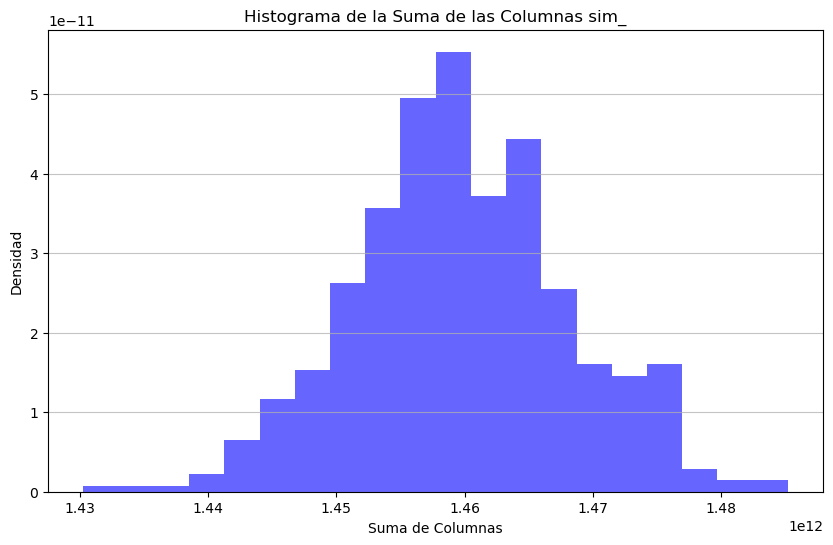

In [67]:
# Crear el histograma de la columna 'suma' del DataFrame df_sum
plt.figure(figsize=(10, 6))
plt.hist(df_sum['suma'], bins=20, density=True, alpha=0.6, color='b')
plt.xlabel('Suma de Columnas')
plt.ylabel('Densidad')
plt.title('Histograma de la Suma de las Columnas sim_')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [62]:
# Calcular el cuantil 95 de la columna 'suma'
cuantil_95 = df_sum['suma'].quantile(0.95)

# Mostrar el resultado
print(f"El cuantil 95 de la suma de las columnas es: {cuantil_95}")

El cuantil 95 de la suma de las columnas es: 1474576028219.2595


In [63]:
from scipy.optimize import minimize_scalar

def calcular_cuantil_95(p, sims=500, d=0.7):
    df_temp = df_sim.copy()
    df_temp['Pago_hoy'] = d * df_temp['Valoracion']

    for i in range(sims):
        aceptados = np.random.binomial(1, p, len(df_temp))
        df_temp[f'sim_{i}'] = df_temp.apply(
            lambda row: row['Pago_hoy'] if aceptados[row.name] == 1 else row['Valoracion'],
            axis=1
        )

    df_temp['suma'] = df_temp[[f'sim_{i}' for i in range(sims)]].sum(axis=1)
    return df_temp['suma'].quantile(0.95)

Total = df_sim['Valoracion'].sum()
objetivo = Total * 0.3

def objetivo_optimizar(p):
    cuantil_95 = calcular_cuantil_95(p)
    ahorro = Total - cuantil_95
    return 0 if ahorro >= objetivo else objetivo - ahorro + 1e6 * (objetivo - ahorro)

resultado = minimize_scalar(objetivo_optimizar, bounds=(0, 1), method='bounded')

In [68]:
print(f"""
Con un {p*100:.2f}% de aceptación, el banco le permite alcanzar (o incluso superar) el objetivo de ahorro del 30%, logrando eficiencia financiera sin comprometer significativamente la aceptación del personal.
""")


Con un 71.39% de aceptación, el banco le permite alcanzar (o incluso superar) el objetivo de ahorro del 30%, logrando eficiencia financiera sin comprometer significativamente la aceptación del personal.

